### 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

In [2]:
def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f) 
    X_train = data["X_train"].copy()
    X_valid = data["X_valid"].copy()
    X_test = data["X_test"].copy()
    y_train = data["y_train"].copy()
    y_valid = data["y_valid"].copy()
    y_test = data["y_test"].copy()
    features = data['feature_selection'].copy()
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features

In [3]:
ROOT_DIR = Path().resolve().parent
WORKING_DIR = Path().resolve()
ROOT_DIR

WindowsPath('C:/Users/Duong/Desktop/ML/Analysis & Model Building')

In [4]:
data_path = ROOT_DIR / 'Data' / 'Final_data.pkl'
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

In [6]:
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1194,1.103362,2,0.795480,2,0.693147,3,1,0.333333,0,0.242857,...,0,0.666667,1.000000,3.401197,-0.620189,0.666667,1.386294,-0.615492,0.693147,-0.595227
128,-1.634185,2,0.355932,1,0.693147,0,5,0.666667,1,1.000000,...,0,0.666667,0.333333,1.386294,-0.620189,0.666667,1.098612,-0.891589,1.098612,-0.875581
810,0.993860,2,0.213559,2,1.098612,0,2,0.000000,1,0.314286,...,0,1.000000,0.333333,3.178054,0.155707,0.666667,2.564949,1.317193,1.609438,1.367249
478,-1.305679,2,0.376271,2,2.564949,0,3,0.333333,1,0.142857,...,0,0.666667,0.000000,2.079442,-1.396086,0.666667,2.079442,-0.063296,0.000000,0.526188
491,0.665354,1,0.642938,1,2.197225,4,3,1.000000,1,0.600000,...,0,0.333333,0.333333,2.397895,0.155707,0.666667,2.197225,0.764998,1.609438,0.806541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,-1.524683,2,0.224859,2,1.945910,2,1,0.666667,1,0.985714,...,1,0.333333,0.333333,1.386294,-0.620189,0.666667,1.386294,-0.615492,0.000000,-0.595227
963,0.117845,2,0.647458,2,0.693147,1,1,0.333333,0,0.014286,...,0,1.000000,0.333333,2.484907,0.155707,0.666667,2.079442,0.764998,0.693147,0.806541
734,-1.634185,2,0.089266,1,2.079442,0,1,0.333333,1,0.914286,...,0,0.000000,0.333333,1.609438,0.155707,0.333333,1.609438,-0.339394,0.693147,-0.875581
1315,-0.101159,2,0.228249,1,0.693147,3,4,1.000000,0,0.614286,...,1,1.000000,0.333333,2.772589,-0.620189,0.666667,0.693147,-1.167687,0.000000,-1.155935


### 2. Model Selection

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, make_scorer, recall_score, f1_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import optuna
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

Ở đây bước ***preprocessing*** và ***Imbalance Handling*** được tách riêng, do đó pipeline sẽ chỉ bao gồm bước ***estimate***

In [47]:
models = {
            'LR': LogisticRegression(max_iter=2000),
            'RFC': RandomForestClassifier(),
            'GaussianNB': GaussianNB(),
            'XGBoost': XGBClassifier(),
            'XGBRF': XGBRFClassifier(),
            'CatBoost': CatBoostClassifier(),
            'LGBM': LGBMClassifier()
        }

In [48]:
mean, std, all_scores = [], [], []

for model_name, model in models.items():
    print(model_name)
    
    pl = Pipeline(
        steps=[
            ('adasyn', ADASYN(random_state=42, sampling_strategy=0.5)),
            ('classifier', model)
        ]
    )
    
    metric = make_scorer(roc_auc_score)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    
    scores = cross_val_score(pl, X_train, y_train, scoring=metric, cv=cv)
    all_scores.append(scores)
    
    print('-' * 30)
    
    mean.append(np.mean(scores))
    std.append(np.std(scores))

LR
------------------------------
RFC
------------------------------
GaussianNB
------------------------------
XGBoost
------------------------------
XGBRF
------------------------------
CatBoost
Learning rate set to 0.011651
0:	learn: 0.6879946	total: 9.08ms	remaining: 9.07s
1:	learn: 0.6823262	total: 16.2ms	remaining: 8.07s
2:	learn: 0.6768248	total: 22.8ms	remaining: 7.58s
3:	learn: 0.6718210	total: 30.4ms	remaining: 7.58s
4:	learn: 0.6672046	total: 37.8ms	remaining: 7.51s
5:	learn: 0.6635309	total: 45.3ms	remaining: 7.5s
6:	learn: 0.6599835	total: 54.5ms	remaining: 7.73s
7:	learn: 0.6557670	total: 61.5ms	remaining: 7.62s
8:	learn: 0.6505212	total: 68.1ms	remaining: 7.5s
9:	learn: 0.6469202	total: 74.3ms	remaining: 7.35s
10:	learn: 0.6422162	total: 81.6ms	remaining: 7.33s
11:	learn: 0.6385532	total: 88ms	remaining: 7.24s
12:	learn: 0.6339208	total: 94.9ms	remaining: 7.2s
13:	learn: 0.6307023	total: 102ms	remaining: 7.15s
14:	learn: 0.6256757	total: 108ms	remaining: 7.12s
15:	learn: 

In [49]:
scores_df = pd.DataFrame()
scores_df['Mean (ROC AUC Score)'] = mean
scores_df['Std'] = std
scores_df.index = models.keys()
scores_df

,Mean (ROC AUC Score),Std
LR,0.720069,0.055134
RFC,0.610029,0.046658
GaussianNB,0.682540,0.046272
XGBoost,0.656330,0.048143
XGBRF,0.629304,0.049938
CatBoost,0.663339,0.053549
LGBM,0.655662,0.054926


In [50]:
from scipy.stats import ttest_ind
import itertools

scores = {
    'Random Forest': all_scores[0],
    'XGBoost': all_scores[2],
    'Catboost': all_scores[4],
    'LightGBM': all_scores[5]
}

ttest_results = []

for model1, model2 in itertools.combinations(scores.keys(), 2):
    score1 = scores[model1]
    score2 = scores[model2]
    stat, p_value = ttest_ind(score1, score2)
    
    ttest_results.append({
        'Score 1': model1,
        'Score 2': model2,
        'P-value': p_value
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df['Conclusion'] = ttest_df['P-value'].apply(lambda x: 'Significant' if x < 0.05 else 'Not significant')
ttest_df

,Score 1,Score 2,P-value,Conclusion
0,Random Forest,XGBoost,4.232076e-04,Significant
1,Random Forest,Catboost,1.754126e-13,Significant
2,Random Forest,LightGBM,1.255158e-06,Significant
3,XGBoost,Catboost,3.392550e-07,Significant
4,XGBoost,LightGBM,6.048592e-02,Not significant
5,Catboost,LightGBM,1.563336e-03,Significant


Từ kết quả trên, ta sẽ lựa chọn mô hình ***Catboost*** và ***LogisticRegression*** để điều chỉnh và huấn luyện

Text(0.5, 1.0, 'Scores Metrics')

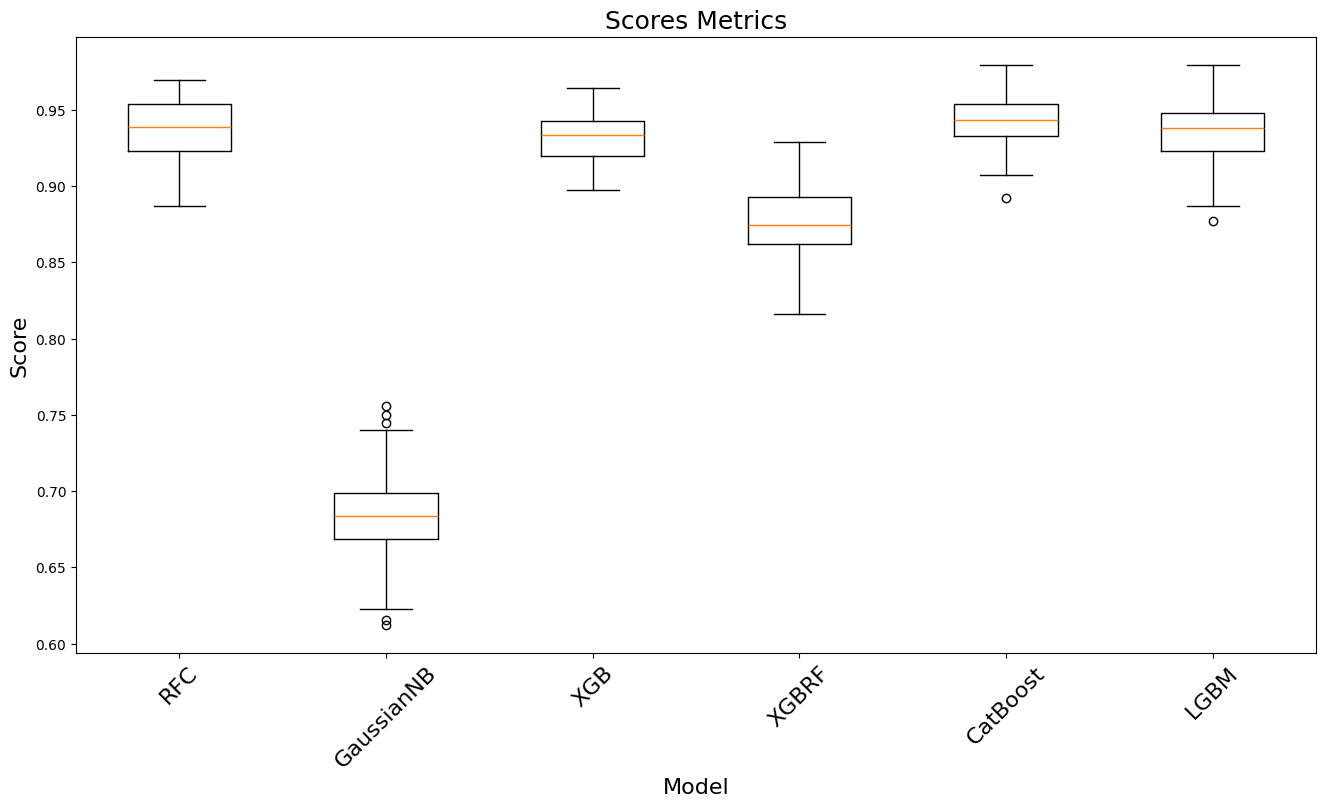

In [12]:
import matplotlib.pyplot as plt
model_names = models.keys()

plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

### 3. Fine-tuning

In [11]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = ada.fit_resample(X_train, y_train)

#### 3.1. CatBoost

In [12]:
def cat_objective(trial, X_train, y_train, X_val, y_val, target='accuracy'):
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'roc_auc': roc_auc_score
    }
    score = metrics.get(target, accuracy_score)

    # Suggest hyperparameters
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])

    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'max_leaves': trial.suggest_int('max_leaves', 20, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ["Lossguide"]),
        'bootstrap_type': bootstrap_type,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 100),
        'verbose': 0,
    }

    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    elif bootstrap_type == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=0)
    
    y_pred = model.predict(X_val)
    return score(y_val, y_pred)


In [13]:
n_trials=100
target = 'f1_score'
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: cat_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

timestamp = int(time.time())
n_features = X_train_resampled.shape[1]
save_path = ROOT_DIR / f"Models/Catboost/catboost_model__{n_features}_features__{target}_objective__{timestamp}.cbm"

best_model = CatBoostClassifier(**study.best_trial.params)
best_model.fit(X_train_resampled, y_train_resampled)

best_model.save_model(save_path)
print(f'Best model saved to {save_path}')

[I 2025-04-14 21:41:30,027] A new study created in memory with name: no-name-1cac2fc2-fef8-4442-8dbe-ef542a1d423f
[I 2025-04-14 21:41:33,247] Trial 0 finished with value: 0.379746835443038 and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1200, 'learning_rate': 0.004976504251180757, 'depth': 9, 'random_strength': 2, 'max_leaves': 27, 'min_data_in_leaf': 14, 'scale_pos_weight': 4.939987793372091, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.015135861477462004, 'border_count': 192, 'od_type': 'IncToDec', 'od_wait': 52, 'subsample': 0.6508310245686857}. Best is trial 0 with value: 0.379746835443038.
[I 2025-04-14 21:41:33,653] Trial 1 finished with value: 0.49056603773584906 and parameters: {'bootstrap_type': 'Bayesian', 'iterations': 900, 'learning_rate': 0.17473911722989904, 'depth': 4, 'random_strength': 19, 'max_leaves': 62, 'min_data_in_leaf': 5, 'scale_pos_weight': 3.0453987255904273, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.005461994633882855, 'border_count': 220, '

0:	learn: 0.6865707	total: 2.59ms	remaining: 3.11s
1:	learn: 0.6828143	total: 5.47ms	remaining: 3.28s
2:	learn: 0.6788683	total: 8.16ms	remaining: 3.25s
3:	learn: 0.6759647	total: 10.7ms	remaining: 3.21s
4:	learn: 0.6728997	total: 12.7ms	remaining: 3.03s
5:	learn: 0.6664876	total: 14.6ms	remaining: 2.9s
6:	learn: 0.6609751	total: 16.6ms	remaining: 2.83s
7:	learn: 0.6572203	total: 18.6ms	remaining: 2.78s
8:	learn: 0.6542118	total: 20.4ms	remaining: 2.69s
9:	learn: 0.6514462	total: 21.8ms	remaining: 2.59s
10:	learn: 0.6477988	total: 23.5ms	remaining: 2.54s
11:	learn: 0.6439101	total: 25.2ms	remaining: 2.5s
12:	learn: 0.6411710	total: 26.8ms	remaining: 2.44s
13:	learn: 0.6388554	total: 28.2ms	remaining: 2.39s
14:	learn: 0.6353132	total: 30ms	remaining: 2.37s
15:	learn: 0.6316939	total: 31.6ms	remaining: 2.34s
16:	learn: 0.6285485	total: 33.2ms	remaining: 2.31s
17:	learn: 0.6234476	total: 34.8ms	remaining: 2.29s
18:	learn: 0.6197726	total: 36.7ms	remaining: 2.28s
19:	learn: 0.6158152	total

#### 3.2. Logistic Regression

In [14]:
def lr_objective(trial, X_train, y_train, X_val, y_val, target='accuracy'):
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'roc_auc': roc_auc_score
    }
    score = metrics.get(target, accuracy_score)

    params = {
    'C': trial.suggest_float('C', 1e-4, 1e2, log=True),  
    'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
    'max_iter': trial.suggest_int('max_iter', 1000, 2000, step = 100),
    }


    if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
        raise optuna.exceptions.TrialPruned()

    model = LogisticRegression(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    return score(y_val, y_pred)


In [ ]:
n_trials=100
target = 'f1_score'
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: lr_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

timestamp = int(time.time())
n_features = X_train_resampled.shape[1]
save_path = ROOT_DIR / f"Models/LogisticRegression/lr_model__{n_features}_features__{target}_objective__{timestamp}.lr"

best_model = LogisticRegression(**study.best_trial.params)
best_model.fit(X_train_resampled, y_train_resampled)

joblib.dump(best_model, save_path)
print(f'Best model saved to {save_path}')

### 4. Evaluation

In [7]:
def plot_cm(clf, validation_set = 'train'):
    if validation_set == 'train':
        X, y = X_train, y_train
    elif validation_set in ['val', 'valid', 'dev'] :
        X, y = X_valid, y_valid
    elif validation_set == 'test':
        X, y = X_test, y_test
    else:
        raise(ValueError(f'Unknown validation-set type: {validation_set}'))
    y_pred = clf.predict(X)
    print(f'Accuracy score: {accuracy_score(y, y_pred):.4f}, ROC-AUC Score: {roc_auc_score(y, y_pred):.4f}, F1-Score: {f1_score(y, y_pred):.4f}')
    ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot()

Catboost

Accuracy score: 0.8095, ROC-AUC Score: 0.6746, F1-Score: 0.4400


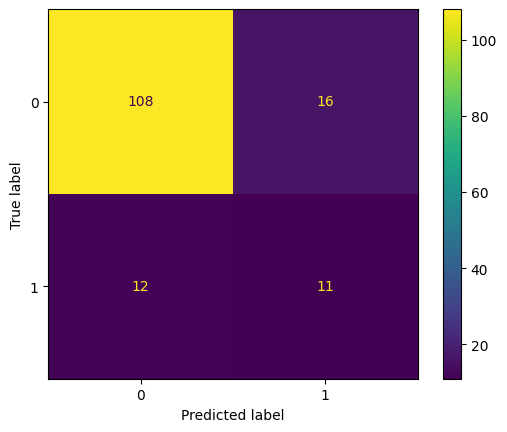

In [9]:
# load model
cat_model = CatBoostClassifier()
cat_model.load_model(ROOT_DIR / 'Models/Catboost/catboost_model__30_features__f1_score_objective__1744091693.cbm')
# plot confusion matrix
plot_cm(cat_model,'test')

Logistic Regression

Accuracy score: 0.8367, ROC-AUC Score: 0.6730, F1-Score: 0.4545


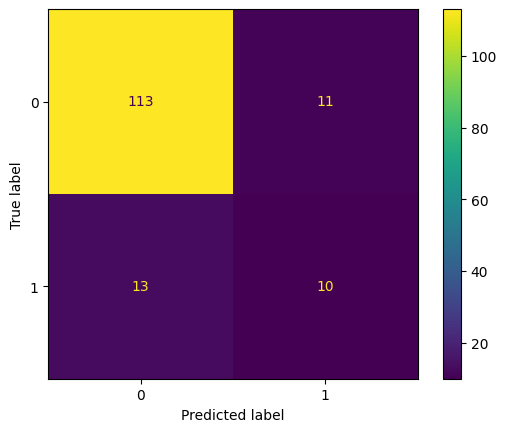

In [10]:
lr_model = joblib.load(ROOT_DIR / 'Models/LogisticRegression/lr_model__30_features__f1_score_objective__1744634573.lr')
plot_cm(lr_model, 'test')

GaussianNB

Accuracy score: 0.6803, ROC-AUC Score: 0.6688, F1-Score: 0.3896


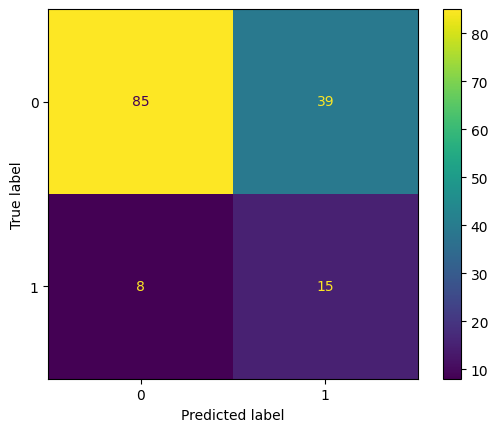

In [244]:
gnb = GaussianNB()
gnb.fit(X_train_resampled, y_train_resampled)
plot_cm('test', gnb)

Stacking

Accuracy score: 0.8163, ROC-AUC Score: 0.6786, F1-Score: 0.4490


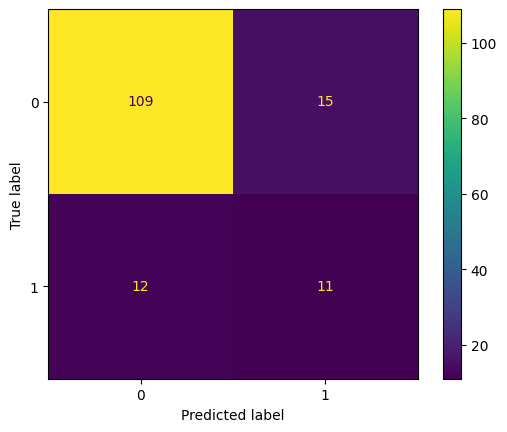

In [ ]:
model = joblib.load(ROOT_DIR / 'Models/Stacking/stacking_model__30_features__f1_score_objective__1744355668.joblib')

plot_cm(model, 'test')

### 5. More Trials

#### 5.1. Less features

In [249]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

In [250]:
features

,RFE,VIF,PCA,Select
Age,1,1,1,1
BusinessTravel,1,0,1,1
DailyRate,1,1,0,1
Department,0,0,1,1
DistanceFromHome,1,1,0,1
Education,0,1,1,1
EducationField,0,1,1,0
EnvironmentSatisfaction,1,1,1,1
Gender,0,1,1,1
HourlyRate,1,1,0,1


##### 5.1.1. 27 features

In [ ]:
# selected_features = features[features['Select'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials=100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: cat_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/Catboost/catboost_model__{n_features}_features__{target}_objective__{timestamp}.cbm"

# best_model = CatBoostClassifier(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# best_model.save_model(save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.7891, ROC-AUC Score: 0.6271, F1-Score: 0.3673


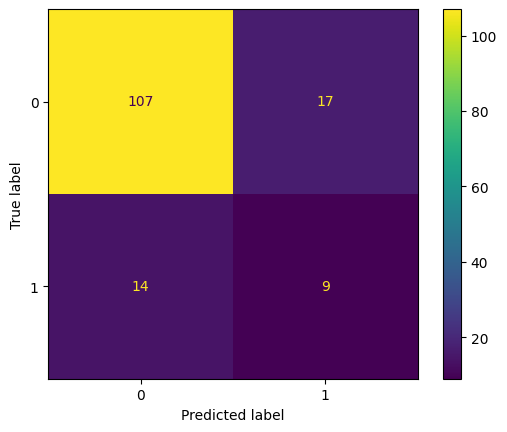

In [ ]:
model = CatBoostClassifier()
model.load_model(ROOT_DIR / 'Models/Catboost/catboost_model__27_features__f1_score_objective__1744046543.cbm')
plot_cm(model, 'test')

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
# selected_features = features[features['Select'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials=100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: lr_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/LogisticRegression/lr_model__{n_features}_features__{target}_objective__{timestamp}.lr"

# best_model = LogisticRegression(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# joblib.dump(best_model, save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.6531, ROC-AUC Score: 0.6173, F1-Score: 0.3377


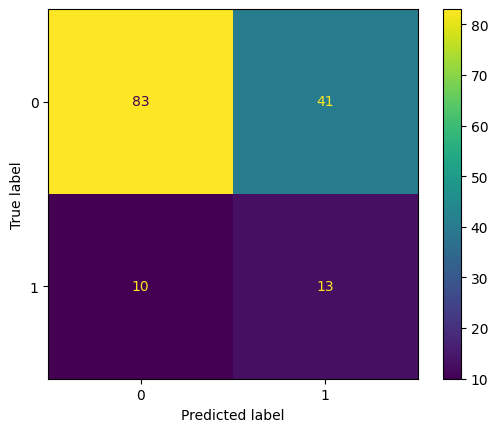

In [ ]:
model = joblib.load(ROOT_DIR / 'Models/LogisticRegression/lr_model__27_features__f1_score_objective__1744429028.lr')
plot_cm(model, 'test')

##### 5.1.2. 24 features

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

# selected_features = features[features['RFE'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials = 100
# target = 'roc_auc'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: cat_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/Catboost/catboost_model__{n_features}_features__{target}_objective__{timestamp}.cbm"

# best_model = CatBoostClassifier(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# best_model.save_model(save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.8027, ROC-AUC Score: 0.5643, F1-Score: 0.2564


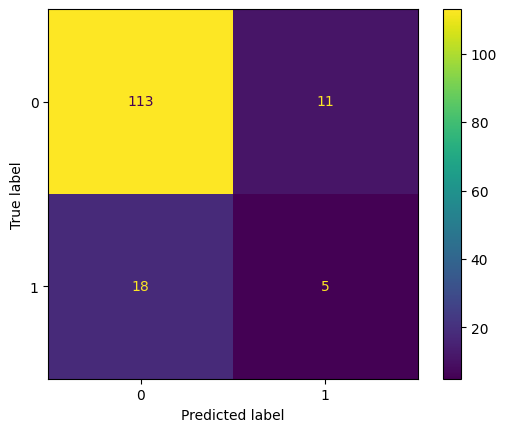

In [ ]:
model = CatBoostClassifier()
model.load_model(ROOT_DIR / 'Models/Catboost/catboost_model__24_features__f1_score_objective__1744048268.cbm')
plot_cm(model, 'test')

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
# selected_features = features[features['RFE'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials=100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: lr_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/LogisticRegression/lr_model__{n_features}_features__{target}_objective__{timestamp}.lr"

# best_model = LogisticRegression(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# joblib.dump(best_model, save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.6735, ROC-AUC Score: 0.6648, F1-Score: 0.3846


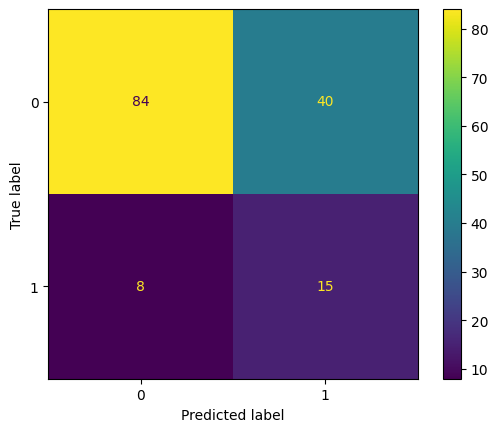

In [ ]:
model = joblib.load(ROOT_DIR / 'Models/LogisticRegression/lr_model__24_features__f1_score_objective__1744429128.lr')
plot_cm(model, 'test' )

##### 5.1.3. 21 features

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

# selected_features = features[features['PCA'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials = 100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: cat_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/Catboost/catboost_model__{n_features}_features__{target}_objective__{timestamp}.cbm"

# best_model = CatBoostClassifier(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# best_model.save_model(save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.8163, ROC-AUC Score: 0.5724, F1-Score: 0.2703


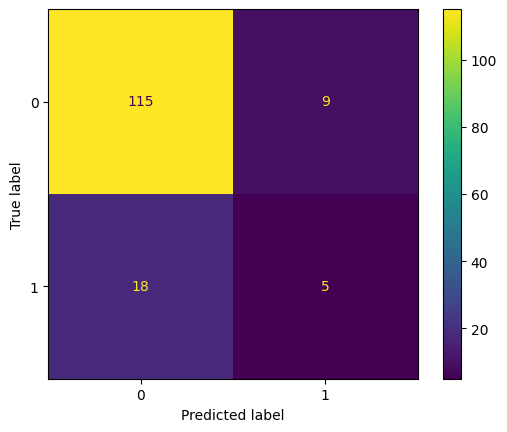

In [ ]:
model = CatBoostClassifier()
model.load_model(ROOT_DIR / 'Models/Catboost/catboost_model__21_features__f1_score_objective__1744048427.cbm')
plot_cm(model, 'test')

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
# selected_features = features[features['PCA'] == 1].index
# X_train = X_train.loc[:, selected_features]
# X_valid = X_valid.loc[:, selected_features]
# X_test = X_test.loc[:, selected_features]

# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials=100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: lr_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/LogisticRegression/lr_model__{n_features}_features__{target}_objective__{timestamp}.lr"

# best_model = LogisticRegression(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# joblib.dump(best_model, save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.6735, ROC-AUC Score: 0.6648, F1-Score: 0.3846


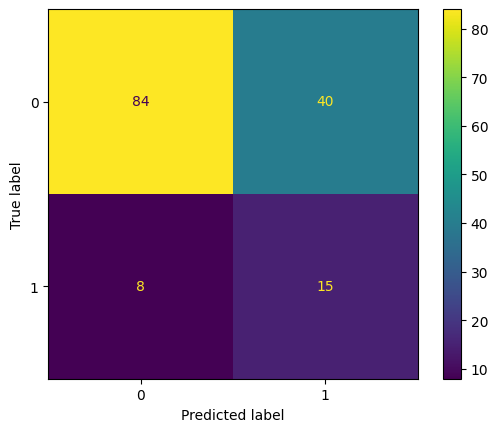

In [ ]:
model = joblib.load(ROOT_DIR / 'Models/LogisticRegression/lr_model__21_features__f1_score_objective__1744429239.lr')
plot_cm(model, 'test' )

##### 5.1.4. 25 features

Kiểm tra này được thực hiện sau khi xem xét feature importance (đi kèm với notebook **Feature Importance.ipynb**)

In [11]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

In [12]:
for X in [X_train, X_valid, X_test]:
    X.drop(columns = ['Education', 'EducationField', 'Department', 'Gender', 'PerformanceRating'], inplace=True)

CatBoost

In [ ]:
adasyn = ADASYN(random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

n_trials = 100
target = 'f1_score'
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: cat_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

timestamp = int(time.time())
n_features = X_train_resampled.shape[1]
save_path = ROOT_DIR / f"Models/Catboost/catboost_model__{n_features}_features__{target}_objective__{timestamp}.cbm"

best_model = CatBoostClassifier(**study.best_trial.params)
best_model.fit(X_train_resampled, y_train_resampled)

best_model.save_model(save_path)
print(f'Best model saved to {save_path}')

Accuracy score: 0.8571, ROC-AUC Score: 0.6497, F1-Score: 0.4324


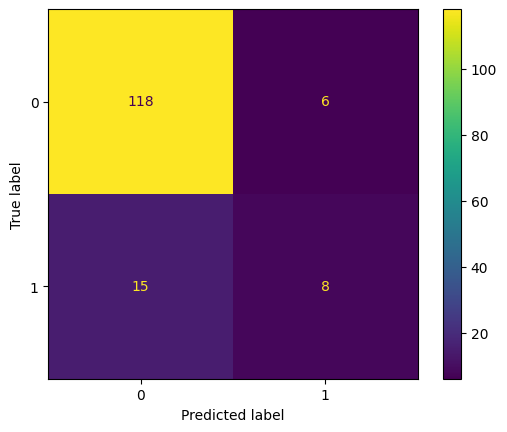

In [ ]:
model = CatBoostClassifier()
model.load_model(ROOT_DIR / 'Models/Catboost/catboost_model__25_features__f1_score_objective__1744344669.cbm')
plot_cm(model, 'test')

Logistic Regression

In [ ]:
# adasyn = ADASYN(random_state=42, sampling_strategy=0.5)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# n_trials = 100
# target = 'f1_score'
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: lr_objective(trial, X_train_resampled, y_train_resampled, X_valid, y_valid, target), n_trials)

# timestamp = int(time.time())
# n_features = X_train_resampled.shape[1]
# save_path = ROOT_DIR / f"Models/LogisticRegression/lr_model__{n_features}_features__{target}_objective__{timestamp}.lr"

# best_model = LogisticRegression(**study.best_trial.params)
# best_model.fit(X_train_resampled, y_train_resampled)

# joblib.dump(best_model, save_path)
# print(f'Best model saved to {save_path}')

Accuracy score: 0.8367, ROC-AUC Score: 0.7085, F1-Score: 0.5000


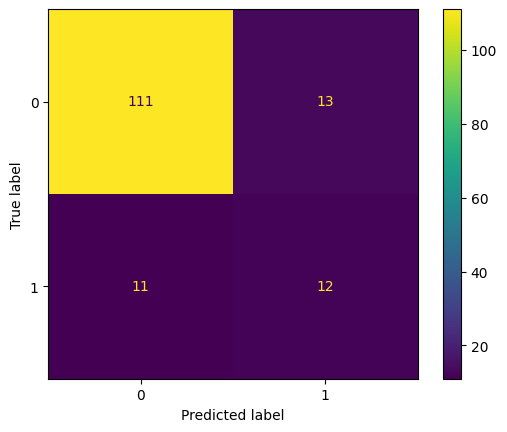

In [14]:
model = joblib.load(ROOT_DIR / 'Models/LogisticRegression/lr_model__25_features__f1_score_objective__1744346019.lr')
plot_cm(model, 'test')

#### 5.2. Stacking model

Sử dụng kết hợp ***Catboost Classifier*** và ***Logistic Regression***

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
for X in [X_train, X_valid, X_test]:
    X.drop(columns = ['Education', 'EducationField', 'Department', 'Gender', 'PerformanceRating'], inplace=True)
adasyn = ADASYN(random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [269]:
from sklearn.ensemble import StackingClassifier

In [ ]:
def stack_objective(trial, X_train, y_train, X_val, y_val, target='accuracy'):
    
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'roc_auc': roc_auc_score
    }
    score = metrics.get(target, accuracy_score)

    # Suggest hyperparameters
    lr_params = {
    'C': trial.suggest_float('C', 1e-4, 1e2, log=True),  
    'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
    'max_iter': trial.suggest_int('max_iter', 1000, 2000, step = 100),
    }

    if lr_params['penalty'] == 'l1' and lr_params['solver'] not in ['liblinear', 'saga']:
        raise optuna.exceptions.TrialPruned()
    
    model1 = LogisticRegression(**lr_params)

    cat_params = {
        'iterations': trial.suggest_int('iterations', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'max_leaves': trial.suggest_int('max_leaves', 20, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ["Lossguide"]),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
    }

    
    meta_model = CatBoostClassifier(**cat_params)

    base_learners = [
        ('LR', model1)
    ]
    
    stacking_model = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_model,
        cv=5,
        passthrough=False,
        n_jobs=-1
    )

    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_val)
    return score(y_val, y_pred)

In [ ]:
n_trials = 100
target = 'f1_score'
study = optuna.create_study(direction='maximize')

study.optimize(lambda trial: stack_objective(trial, 
                                       X_train_resampled, y_train_resampled, 
                                       X_valid, y_valid, 
                                       target = target), n_trials)

[I 2025-04-11 14:22:43,350] A new study created in memory with name: no-name-77b75ac9-29c9-4410-a0fb-98c350fe1020
[I 2025-04-11 14:22:43,961] Trial 0 finished with value: 0.5 and parameters: {'C': 0.00015323210281954872, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1900, 'iterations': 700, 'learning_rate': 0.0021228586673233706, 'depth': 10, 'random_strength': 16, 'max_leaves': 48, 'min_data_in_leaf': 12, 'scale_pos_weight': 0.969566917148768, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.006007557952730638, 'border_count': 189}. Best is trial 0 with value: 0.5.
[I 2025-04-11 14:22:45,470] Trial 1 finished with value: 0.6707317073170732 and parameters: {'C': 0.02956160139061239, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1000, 'iterations': 1500, 'learning_rate': 0.0027365090004653533, 'depth': 7, 'random_strength': 20, 'max_leaves': 62, 'min_data_in_leaf': 3, 'scale_pos_weight': 2.0963684795059234, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 0.0020928519137839914, 'border_count': 

In [204]:
best_params = study.best_trial.params

base_learner = LogisticRegression(
    C = best_params['C'],
    penalty = best_params['penalty'],
    solver = best_params['solver'],
    max_iter = best_params['max_iter']
    )

meta_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    verbose=0,
    random_state=42,
    random_strength=best_params['random_strength'],
    max_leaves = best_params['max_leaves'],
    min_data_in_leaf = best_params['min_data_in_leaf'],
    scale_pos_weight = best_params['scale_pos_weight'],
    grow_policy =  'Lossguide',
    l2_leaf_reg = best_params['l2_leaf_reg'],
    border_count = best_params['border_count']
)

model = StackingClassifier(
    estimators=[('LR', base_learner)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

In [ ]:
timestamp = int(time.time())
n_features = X_train_resampled.shape[1]
os.makedirs('Models/Stacking/', exist_ok=True)

save_path = ROOT_DIR / f"Models/Stacking/stacking_model__{n_features}_features__{target}_objective__{timestamp}.joblib"

model.fit(X_train, y_train)

joblib.dump(model, save_path)

print(f'Best model saved to {save_path}')

Accuracy score: 0.8503, ROC-AUC Score: 0.6988, F1-Score: 0.5000


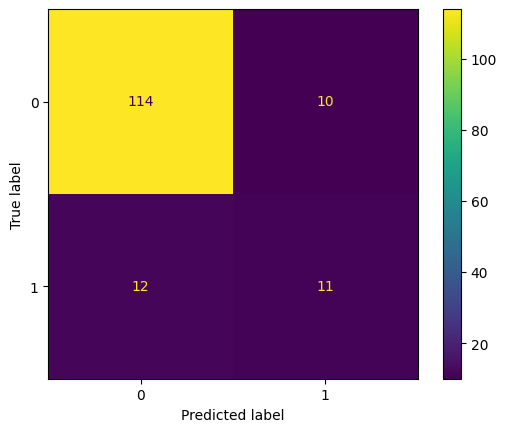

In [ ]:
model = joblib.load(ROOT_DIR / 'Models/Stacking/stacking_model__25_features__f1_score_objective__1744355936.joblib')

plot_cm(model, 'test')